# Imports

In [2]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

_________________

**Helper Functions**

In [2]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

_________

Skip to section 2.3 to load the large dataframe after initial EDA and processing. Then all cells in the remainder of section 2 and beyond can be executed.

# EDA

## Movie Details

In [3]:
movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)
display(movie_details.info())
movie_details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


None

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
...,...,...,...,...,...,...,...
1567,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1568,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
1569,tt5013056,Evacuation of Allied soldiers from the British...,1h 46min,"[Action, Drama, History]",8.1,2017-07-21,The film alternates between three different pe...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


Convert 'release_date' to a datetime object

In [4]:
movie_details['release_date'] = pd.to_datetime(movie_details.release_date)

Convert duration into a minute count (integer)

In [5]:
hour = re.compile('(\d+)h')
minute = re.compile('(\d+)min')

def duration_convert(df):
    # set intial duration to 0
    duration = 0
    # find number of hours and minutes
    hour_found = hour.findall(df.duration)
    minute_found = minute.findall(df.duration)
    # if hours, multiply value by 60 and add to duration
    if hour_found:
        duration += 60 * int(hour_found[0])
    # if minutes, add to duration
    if minute_found:
        duration += int(minute_found[0])
    # return total number of minutes
    return duration

movie_details['duration'] = movie_details.apply(duration_convert, axis=1)

Confirm that genre contains lists for possible future genre analysis

In [6]:
for i in list(range(len(movie_details))):
    count = 0
    if str(type(movie_details.iloc[i].genre)) != "<class 'list'>":
        count += 1
        print(type(movie_details.iloc[i].genre))
print(f"There are {count} entries for genre that are not a list")

There are 0 entries for genre that are not a list


There are some movie_ids that have a trailing forward slash, we need to fix that to merge the data

In [7]:
def fix_movie_id(df):
    if df.movie_id[-1] == '/':
        return  df.movie_id[:-1]
    else:
        return df.movie_id

movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

In [16]:
movie_details.describe(datetime_is_numeric=True)

,duration,rating,release_date
count,1572.000000,1572.000000,1572
mean,115.269084,7.071819,2001-06-20 14:17:24.274809216
min,42.000000,2.400000,1921-02-06 00:00:00
25%,100.000000,6.500000,1995-08-23 06:00:00
50%,113.000000,7.100000,2003-07-05 12:00:00
75%,128.000000,7.800000,2010-12-04 18:00:00
max,321.000000,9.500000,2018-02-15 00:00:00
std,24.544471,0.967966,NaN


The numerical data for our films being reviews shows:
- Average film is 115 minutes, with a range of 42 to 321 minutes
- Average rating is a 7, with a range from 2.4 to 9.5
- The oldest film is from 1921, but the vast majority are released after 1995

### plot summary / synopsis

In [8]:
empty_summary = len(movie_details[movie_details.plot_summary == ''])
empty_synopsis = len(movie_details[movie_details.plot_synopsis == ''])
print(f"There are {empty_summary} entries with an empty summary.\nThere are {empty_synopsis} entries with an empty synopsis.")

There are 0 entries with an empty summary.
There are 233 entries with an empty synopsis.


In [9]:
first_summary_len = len(movie_details.iloc[0].plot_summary)
first_synopsis_len = len(movie_details.iloc[0].plot_synopsis)
print(f"The first entry summary length is: {first_summary_len}\nThe first entry synopsis length is: {first_synopsis_len}")

The first entry summary length is: 1034
The first entry synopsis length is: 8605


In [10]:
no_synopsis_ids = list(movie_details[movie_details.plot_synopsis == '']['movie_id'])

with open('no_synopsis_ids.pkl', 'wb') as f:
    pickle.dump(no_synopsis_ids, f)

# load the saved list of indicies
with open('no_synopsis_ids.pkl', 'rb') as f:
    no_synopsis_ids = pickle.load(f)

The first entry's summary and synopsis reveals that the former is shorter than the latter, which is the field containing some missing values. Checking the whole dataframe to see if that relationship is always the case.

In [11]:
count = 0

for i in list(range(len(movie_details))):
    if movie_details.iloc[i].plot_synopsis != '':
        summary_len = len(movie_details.iloc[i].plot_summary)
        synopsis_len = len(movie_details.iloc[i].plot_synopsis)
        if summary_len > synopsis_len:
            count += 1
    
print(f"There are {count} entries with a synopsis where the summary length is greater than the synopsis length.")

There are 23 entries with a synopsis where the summary length is greater than the synopsis length.


It would be best to use the film synopsis as it is longer and contains more detail about the film. But we are missing 233 synopses from the data. We have saved the film_ids for these films with missing synopsis. With that many missing, we will use the film summary instead of synopsis if we explore cosine similarity as an approach to spoiler detection.

## Movie Reviews

In [12]:
movie_reviews = pd.read_json('./data/IMDB_reviews.json', lines=True)
display(movie_reviews.info())
movie_reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


None

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In [13]:
unique_movies_in_reviews = movie_reviews.movie_id.nunique()
print(f"There are {len(movie_details)} entries in movie_details and {unique_movies_in_reviews} unique movie_id's in movie_reviews")

There are 1572 entries in movie_details and 1572 unique movie_id's in movie_reviews


Converting the review_date to datetime

In [14]:
movie_reviews['review_date'] = pd.to_datetime(movie_reviews.review_date)

In [15]:
movie_reviews.describe(datetime_is_numeric=True)

,review_date,rating
count,573913,573913.000000
mean,2009-07-20 04:42:25.548193280,6.954254
min,1998-07-28 00:00:00,1.000000
25%,2005-06-18 00:00:00,5.000000
50%,2009-07-25 00:00:00,8.000000
75%,2014-05-15 00:00:00,10.000000
max,2018-01-07 00:00:00,10.000000
std,NaN,2.956295


The only numerical features from movie reviews are the date of the review and the rating. If we look at these compared to the data from the films being reviewed, we see:
- The reviews are mostly from 2005 and later
- The user rating is, on average, the same as the metadata rating. The range is larger, from 1 to 10

### Entity extraction, character and word counts

We initially had interest in entitiy extraction to compare reviews with spoilers to those without. This processing takes just under 8 hours for the review text, much shorter for the synopsis text. The functions were manually changed to pull the correct text when performing the same processing on the synopsis text.

In [ ]:
# nlp = spacy.load('en_core_web_sm')

# def entity_info(row):
#     # get the review text
#     review = row.review_text
#     # generate new features for character and word count of the summary
#     row['char_count'] = len(review)
#     row['word_count'] = len(review.split(' '))
#     # get the entities with spacy
#     doc = nlp(review)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['entity_count'] = len(ent_list)
#     row['unique_entities'] = unique_ents
#     row['avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_reviews = movie_reviews.apply(entity_info, axis=1)

We also had interest in character and word counts, which is what this cell does.

In [ ]:
# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def review_tokenize(row):
#     # get the film review
#     review = row.review_text
#     # tokenize
#     review_tokens = tokenizer.tokenize(review)
#     review_tokens = [token.lower() for token in review_tokens]
#     review_tokens = [token for token in review_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['review_tokens'] = review_tokens
#     row['review_token_count'] = len(review_tokens)
#     return row

# movie_reviews = movie_reviews.apply(review_tokenize, axis=1)

## Merge/Load all data

To save time, the processing was performed once, the data merged, and the file saved to disk for easier loading later.

In [1]:
# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how="right")

# corrected_columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'film_rating',
#                      'release_date', 'plot_synopsis', 'summary_char_count',
#                      'summary_word_count', 'summary_entity_count', 'summary_unique_entities',
#                      'summary_avg_entity_freq', 'summary_tokens', 'summary_token_count',
#                      'review_date', 'user_id', 'is_spoiler', 'review_text', 'reviewer_rating',
#                      'review_summary', 'review_char_count', 'review_word_count', 'review_entity_count',
#                      'review_unique_entities', 'review_avg_entity_freq', 'review_tokens',
#                      'review_token_count']

# merged_df.columns = corrected_columns

# merged_df.to_parquet('./data/full_dataframe.parquet')

This cell reads in the full dataframe from the saved parquet file. The file is large, 573,913 entries with 27 features, takes up about 1.9 GB of space. The load takes about a minute

In [4]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')
# set the is_spoiler target to integer values
merged_df['is_spoiler'] = merged_df.is_spoiler.astype(int)

# Exploring reviews

In [5]:
merged_df.review_word_count.describe()

count    573913.000000
mean        259.399052
std         195.438284
min           1.000000
25%         131.000000
50%         189.000000
75%         322.000000
max        2673.000000
Name: review_word_count, dtype: float64

## Word Count

In [6]:
outlier_wc = round(merged_df.review_word_count.mean() + (3 * merged_df.review_word_count.std()),)
print("Upper outlier boundary for word count:", outlier_wc)
print("Lower 2.5% reviews word count:", merged_df.review_word_count.quantile(0.025))
print("Upper 2.5% reviews word count:", merged_df.review_word_count.quantile(0.975))

Upper outlier boundary for word count: 846
Lower 2.5% reviews word count: 54.0
Upper 2.5% reviews word count: 848.0


We saw that our minimum review word count is 1, and our maximum is 2673, but our average is just about 260 words. Defining outliers as 3x the std from the mean, we would not have any lower bound outliers, and our upper bound outliers would be 846 words. Our bottom 2.5% of reviews contains fewer words than 54 and our upper 2.5% contain more words than 848, which is close to the threshold we calculated for outliers.

54 words is still quite a few and our model may see value in reviews with that many words, but there may not be value in reviews that are really short.

Lets explore restricting reviews by length by looking at the counts for reviews with low word counts. We can modify the max_count value in this next cell to get the frequency by word count, total, and the indicies of all the reviews in question for easy removal

In [7]:
total = 0
min_count = 1
max_count = 54
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {max_count} or fewer words.")

There are 14512 reviews containing 54 or fewer words.


In [8]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

0    14211
1      301
Name: is_spoiler, dtype: int64

In [9]:
total = 0
min_count = 846
max_count = 2673
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     if count > 0:
#         print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {min_count} or more words.")

There are 14518 reviews containing 846 or more words.


In [10]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

1    7437
0    7081
Name: is_spoiler, dtype: int64

There are 14,512 reviews under 54 words and most of them (97.9%) are not spoilers. There are 14,518 reviews over 846 words, and unfortunately they contain a small majority of spoilers, much more by percent than our whole dataset. 

We also discovered through investigation that we have some not english text in reviews, one example in review at iloc 1533. We will engineer a new feature using langdetect to flag any reviews that are not in english.

## Language

In [11]:
merged_df.iloc[1533].review_text

'Izledigim filmeler arasinda pek hayli yer kaplamaktadir'

In [12]:
detect(merged_df.iloc[1533].review_text)

'tr'

In [13]:
# def non_english_review(df):
#     review = df.review_text
#     if detect(review) != 'en':
#         return 1
#     else:
#         return 0

# this takes about an hour and a half
# merged_df['non_english_review'] = merged_df.apply(non_english_review, axis=1)

# pulling the index values of those entries with non-english reviews
# non_english_reviews = list(merged_df[merged_df.non_english_review == 1].index)
# going to save this to a pickle file to load later for removing these reviews instead of processing
# each time
# with open('non_english_reviews.pkl', 'wb') as f:
#     pickle.dump(non_english_reviews, f)

# load the saved list of indicies
with open('non_english_reviews.pkl', 'rb') as f:
    non_english_reviews = pickle.load(f)

# look at how many non-english reviews we have
print(f"Number of non-english reviews: {len(non_english_reviews)}")

Number of non-english reviews: 53


With so few non-english reviews, we will remove them from consideration in modeling.

Something we're not sure about is restricting our reviews based on word count, specifically very low or very high counts. Our average review count was about 260, so we are concerned about picking up on what is spoiler-y in those 'outlier' word count reviews.

In [14]:
merged_df.drop(non_english_reviews, inplace=True)
merged_df.reset_index(drop=True, inplace=True)

## WordCloud

In [3]:
review_df = pd.read_parquet('./data/reviews_lemmed.parquet', columns=['is_spoiler', 'review_text_lemmed'])

In [4]:
spoiler_words = review_df[review_df.is_spoiler == 1]['review_text_lemmed'].str.cat(sep=' ')
non_spoiler_words = review_df[review_df.is_spoiler == 0]['review_text_lemmed'].str.cat(sep=' ')

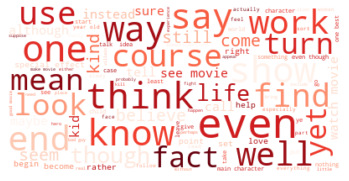

In [5]:
spoiler_wordcloud = WordCloud(max_font_size=50, max_words=100, 
                              background_color='white', colormap='Reds').generate(spoiler_words)

plt.figure()
plt.imshow(spoiler_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [6]:
spoiler_wordcloud.to_file('spoiler_wordcloud.png')

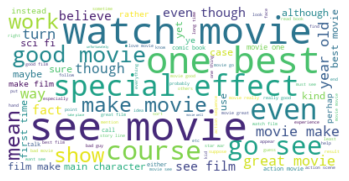

<Figure size 432x288 with 0 Axes>

In [20]:
non_spoiler_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(non_spoiler_words)

plt.figure()
plt.imshow(non_spoiler_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [24]:
non_spoiler_wordcloud.to_file('non_spoiler_wordcloud.png')

## Spoiler Frequency

In [ ]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')


In [15]:
merged_df[merged_df.is_spoiler == 1].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count
count,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.0,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000
mean,121.128488,7.280335,624.412116,117.460476,9.187166,7.519770,1.195448,59.631129,1.0,6.517444,1887.806353,334.917997,17.256658,13.035869,1.256000,173.768132
std,24.940509,0.948578,237.507669,41.978237,5.533896,4.162631,0.294973,22.896131,0.0,3.015920,1283.836091,223.268510,15.865774,10.606327,0.369353,118.606237
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.0,1.000000,50.000000,8.000000,0.000000,0.000000,0.000000,6.000000
25%,105.000000,6.700000,427.000000,82.000000,5.000000,4.000000,1.000000,41.000000,1.0,4.000000,920.000000,166.000000,6.000000,6.000000,1.000000,85.000000
50%,119.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,57.000000,1.0,7.000000,1459.000000,261.000000,12.000000,10.000000,1.170000,135.000000
75%,136.000000,8.000000,803.000000,147.000000,12.000000,10.000000,1.310000,77.000000,1.0,9.000000,2456.000000,435.000000,23.000000,17.000000,1.380000,226.000000
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,1.0,10.000000,14302.000000,2565.000000,176.000000,129.000000,22.000000,1295.000000


In [16]:
merged_df[merged_df.is_spoiler == 0].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count
count,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.0,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000
mean,120.942258,7.298362,627.099151,118.291786,9.237148,7.556064,1.196654,60.078550,0.0,7.109942,1308.228097,232.475417,11.541337,9.341266,1.148739,120.600954
std,25.483269,0.963061,238.361767,42.148804,5.541603,4.174879,0.296576,22.920888,0.0,2.918918,1021.058027,176.857874,12.086183,8.651151,0.351401,94.618036
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.0,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,2.000000
25%,104.000000,6.700000,431.000000,83.000000,5.000000,4.000000,1.000000,41.000000,0.0,5.000000,682.000000,124.000000,4.000000,4.000000,1.000000,63.000000
50%,118.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,58.000000,0.0,8.000000,947.000000,171.000000,8.000000,7.000000,1.070000,87.000000
75%,135.000000,8.000000,800.000000,148.000000,12.000000,10.000000,1.310000,78.000000,0.0,10.000000,1575.000000,280.000000,14.000000,12.000000,1.250000,145.000000
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,0.0,10.000000,14963.000000,2673.000000,213.000000,179.000000,27.000000,1333.000000


Initial observations from the describe calls on reviews marked as spoiler versus ones that are not:
- The reviewer rating is about half a point lower on average for reviews marked as spoilers
- The review word count of a spoiler review is longer on average by about 36% (232 -> 335), but does have a more variation
- Rougly the same can be said about the entity counts (raw and unique)

It looks like there is nothing glaringly obvious about the difference between spoiler and non-spoiler reviews in terms of entities or raw word counts

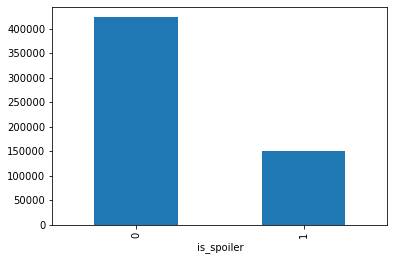

In [17]:
merged_df.groupby('is_spoiler').size().plot(kind='bar');

## Spoiler by genre

Pull just the genre feature along with the target 'is_spoiler' so that each film is represented in each genre it's a part of.

In [18]:
genres = merged_df[['genre', 'is_spoiler']].explode('genre').copy()

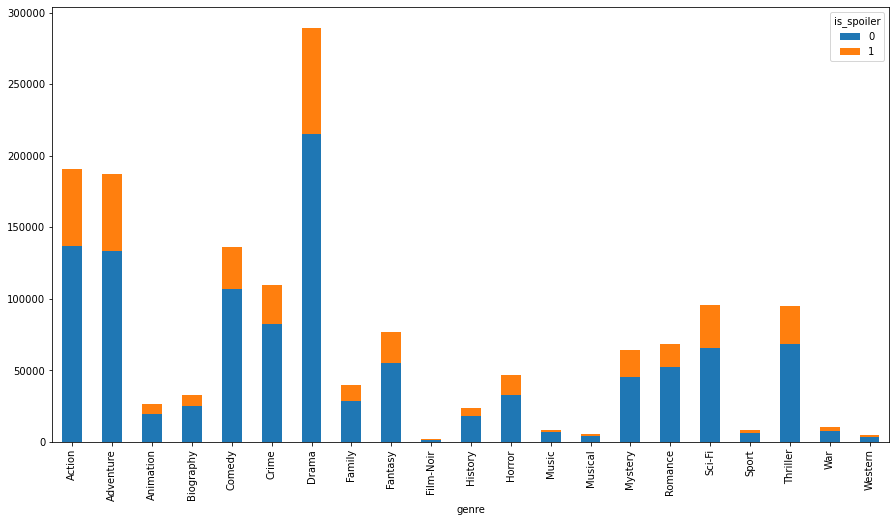

In [19]:
genres.groupby(['genre', 'is_spoiler']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,8));

## Spoilers by UserID

In [20]:
user_ids = merged_df[['user_id', 'is_spoiler']].copy()
user_ids.user_id.value_counts()

ur2898520     1303
ur4248714     1021
ur0453068      806
ur60028700     770
ur20552756     755
              ... 
ur23470975       1
ur50774218       1
ur49925358       1
ur47767082       1
ur0156431        1
Name: user_id, Length: 263362, dtype: int64

In [21]:
user_ids.user_id.value_counts().values.sum() / len(user_ids.user_id.value_counts())

2.178977984675086

There are 263,407 unique users represented in the data. We can see that the vast majority do not comment more than once. The average number of comments is 2.17. Lets look at our top 20 commenters.

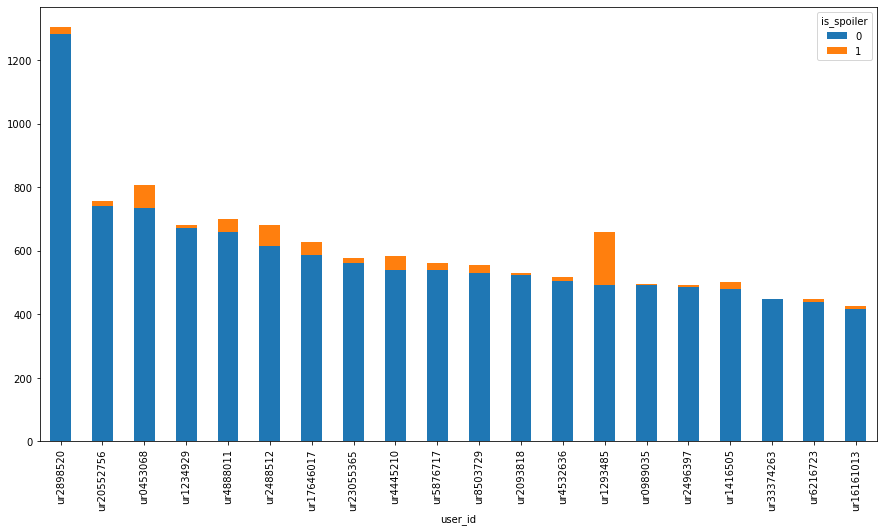

In [22]:
# top 20 reviewers by total count, separated into spoiler/non
user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)[:20].plot(kind='bar', stacked=True, figsize=(15,8));

# Non-language feature modeling

We thought it would be interesting to model using the non-language features of our data. Features which don't pertain to the summary or review text include:
- film duration
- genre
- rating
- release date
- review date
- is_spoiler (target)

In [23]:
non_lang_features = ['duration', 'genre', 'film_rating', 'release_date', 'review_date',
                     'is_spoiler']
non_language_df = merged_df[non_lang_features].copy()

Engineer a new feature: age of film at review

In [24]:
def film_age(df):
    age = df.review_date - df.release_date
    return age.days

non_language_df['days_since_release'] = non_language_df.apply(film_age, axis=1)
non_language_df.drop(['release_date', 'review_date'], axis=1, inplace=True)

Explode the genres. [Inspiration](https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list)

In [25]:
s = non_language_df['genre'].explode()
non_language_df = non_language_df[['duration', 'film_rating', 'is_spoiler',
                                   'days_since_release']].join(pd.crosstab(s.index, s))

## SGD Classifier

We are going to try using a SGD classifer to see how well it performs

In [26]:
# set X and y
X = non_language_df.drop('is_spoiler', axis=1)
y = non_language_df['is_spoiler']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the predictors
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Performing a grid search for optimized parameters. This runs in about 18 minutes, so it's commented out and the best parameters are listed below

In [27]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10, n_jobs=-1)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

Best params were:
- alpha: 0.0001
- loss: 'hinge'
- penalty: 'l2'

In [28]:
sgd_model = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
sgd_model.fit(X_train_s, y_train)

SGDClassifier()

In [29]:
y_pred = sgd_model.predict(X_test_s)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84696
     spoiler       0.00      0.00      0.00     30076

    accuracy                           0.74    114772
   macro avg       0.37      0.50      0.42    114772
weighted avg       0.54      0.74      0.63    114772



C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


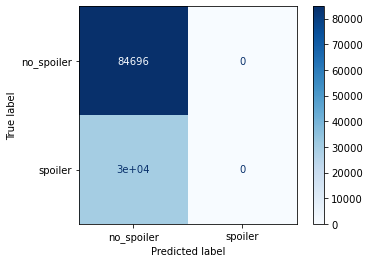

In [30]:
report(y_test, y_pred)

Modeling on the film review metadata we have does not look promising.

# Data Preparation

Pulling the summaries into one dataframe and the reviews into another, retaining the movie_id for eventual combination.

The lemmatizing of the reviews done in 6.1 takes about an hour and a half, so to save time we processed it and save the files as parquet files. All we need to do is import the files.

**Since we performed the lemmatizing, we have discovered some non-english reviews. We have the indicies to remove them generated in section 3, stored in a variable non_english_reviews. That variable is also saved as a pickle file so we can load it and drop the indicies of the non-english reviews.**

In [143]:
# # these lines are the original creation of the dataframes
# summary_df = merged_df[['movie_id', 'plot_summary']].copy()
# summary_df.drop_duplicates(inplace=True)
# summary_df.reset_index(drop=True, inplace=True)
# review_df = merged_df[['movie_id', 'review_text', 'is_spoiler']].copy()

# deleting the merged_df
# del merged_df

In [31]:
# loading the reviews, contains both original and lemmed field
review_df = pd.read_parquet('./data/reviews_lemmed.parquet')
# loading the summaries, contains both original and lemmed field
summary_df = pd.read_parquet('./data/plot_summary_lemmed.parquet')

After the original lemmatization of the reviews, we discovered that there were some non-english reviews that existed in our data. In 2.3.1 we identified the indicies of the non-english reviews and then saved that list in a pickle file. Here, we load that list and use it to remove those few non-english reviews rows from the dataframe.  

In [4]:
with open('non_english_reviews.pkl', 'rb') as f:
    non_english_reviews = pickle.load(f)

# dropping non english reviews
review_df.drop(non_english_reviews, axis=0, inplace=True)
review_df.reset_index(drop=True, inplace=True)

## lemmatization (already processed)

This was performed once and then the dataframe was saved. It's left here in case we need to modify and reprocess the lemmatization.

In [13]:
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# helper function to clean and lemmatize the review
def lem_review(df):
    # get the doc text
    doc = df.review_text
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

# helper function to clean and lemmatize the summary
def lem_summary(df):
    # get the doc text
    doc = df.plot_summary
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

In [14]:
# this takes about an hour and a half
# review_df['review_text_lemmed'] = review_df.apply(lem_review, axis=1)

# this takes about 9 seconds
# summary_df['plot_summary_lemmed'] = summary_df.apply(lem_summary, axis=1)

Because it took so long to lemmatize the reviews, we are going to save both of these dataframes as parquet files to make modeling easier on ourselves.

In [16]:
# review_df.to_parquet('./data/reviews_lemmed.parquet')
# summary_df.to_parquet('./data/plot_summary_lemmed.parquet')